<h2><center>EParisot's Starter Code for IceBerg Detection</center></h2>

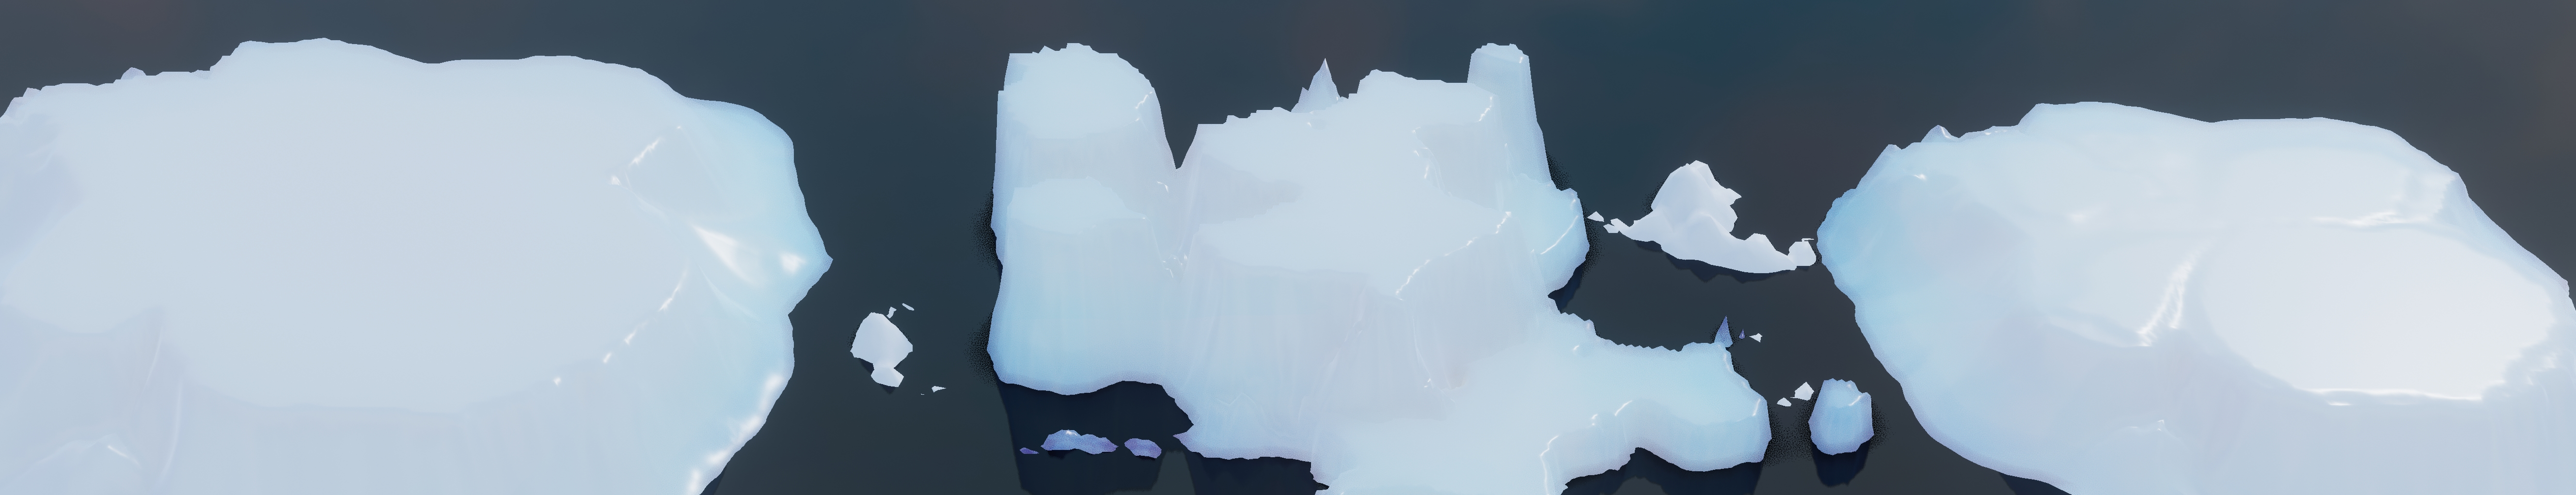
### What we are going to Learn

  - How to build a DataGenerator using Tensoflow.Keras API
  - How to semantic segmentation using TensorFlow.
  - Working with videos.

### Install packages

In [3]:
# Installing Scikit Video & FFMPEG
!pip install scikit-video
!pip install ffmpeg
!apt-get install ffmpeg gstreamer1.0-libav vlc
!apt-get update -qq && sudo apt-get -y install \
  autoconf \
  automake \
  build-essential \
  cmake \
  git-core \
  libass-dev \
  libfreetype6-dev \
  libgnutls28-dev \
  libsdl2-dev \
  libtool \
  libva-dev \
  libvdpau-dev \
  libvorbis-dev \
  libxcb1-dev \
  libxcb-shm0-dev \
  libxcb-xfixes0-dev \
  meson \
  ninja-build \
  pkg-config \
  texinfo \
  wget \
  yasm \
  zlib1g-dev
!apt-get install ffmpeg libsm6  libxext6 -y
!pip install sk-video p-tqdm
!apt-get update
# install opencv and tf
!apt-get install -y python3-opencv
!pip install tensorflow
# utility that will help in getting the files in the right order
!pip install natsort

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
gstreamer1.0-libav is already the newest version (1.14.5-0ubuntu1~18.04.1).
vlc is already the newest version (3.0.8-0ubuntu18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 81 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'git' instead of 'git-core'
autoconf is already the newest version (2.69-11).
automake is already the newest version (1:1.15.1-3ubuntu2).
build-essential is already the newest version (12.4ubuntu1).
libtool is already the newest version (2.4.6-2).
libvorbis-dev is already the newest version (1.3.5-4.2).
pkg-config is already the newest version (0.29.1-0ubuntu2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libass-dev is already the newest version (1:0.14.0-1).
libva-dev is already the newest version (2.1.0-3

In [52]:
# Tensorflow Keras
import tensorflow.keras as keras

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt

import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
from glob import glob
import skvideo.io

### Dataloader

Ok Here we go for the real first work we have to do: A DataGenerator !

Why is it usefull ? Well, you may not want to load all the dataset in your RAM...

Using a generator, every single data will be readen and used on the go, so you never store more than a batch in memory... This gives you the ability to control your machine's ressources !

Here we go !

In [53]:
# Here we define the frame's shape 
# (note that we will use the same shape for input and output images, 
# since we want to operate segmentation from grayscale images, with the same size output)
img_dims = (128, 128, 1)
# and the number of frame we will find in every video
nb_frames = 23

class VideoDataGenerator(keras.utils.Sequence):
    
    def __init__(self, data_folder="data/train", task="train", split=0.8, img_dims=img_dims, batch_size=nb_frames, shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.dims = img_dims
        self.task = task
        self.data_directory = data_folder
        # here we grab the images from folder in correct order (filenames are indexes)
        # if not in test config, we also grab the segmentations from correct folder
        # then we build a new array with the images/segmentations pair (or just images for testing)
        self.image_videos_files = natsorted(glob(self.data_directory+"/image*"))
        if self.task != "test":
            self.segmentation_videos_files = natsorted(glob(self.data_directory+"/segmentation*"))
            self.img_list = list(zip(self.image_videos_files, self.segmentation_videos_files))
        else:
            self.img_list = [[f] for f in self.image_videos_files]
        # here we compute the total number of batches
        self.nb = len(self.img_list) * nb_frames
        # then we apply the split validation
        self.split = int(split * self.nb)
        self.shuffle = shuffle
        # execute on init because no epoch ends a start
        self.on_epoch_end()
        
    def __len__(self):
        # Return the number of batches for train, val and test
        if self.task == "train":
            l = self.split // self.batch_size
        elif self.task == "val":
            l = (self.nb - self.split) // self.batch_size
        else:
            l = self.nb / self.batch_size
        return l

    def __getitem__(self, idx):
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        # Updates indexes after each epoch (and shuffle if needed)
        self.indexes = np.arange(self.nb)
        if self.task == "train":
            self.indexes = self.indexes[:self.split]
        elif self.task == "val":
            self.indexes = self.indexes[self.split:]
        if self.task != "test" and self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        # Arrays Initializations
        X = np.empty((self.batch_size, *self.dims), dtype=np.float32)
        if self.task != "test":
            Y = np.empty((self.batch_size, *self.dims), dtype=np.float32)
        # Generate data
        for i, idx in enumerate(indexes):
            # Reading The iceberg video
            img_video = cv2.VideoCapture(self.img_list[idx // nb_frames][0])
            if self.task != "test":
                seg_video = cv2.VideoCapture(self.img_list[idx // nb_frames][1])
            # compute the n of image from idx (nb_frames images per video, 1 video per idx)
            n = idx % nb_frames
            # grab the correct image and copy it as X
            img_video.set(1, n)
            ret, img = img_video.read()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.array(img, dtype=np.float32)
            img = cv2.resize(img, self.dims[:2])
            X[i,] = np.expand_dims(np.squeeze(img) / 255., axis=2) 

            # Reading the segmentation video
            if self.task != "test":
                seg_video.set(1, n)
                ret, mask = seg_video.read()
                mask = cv2.resize(mask, self.dims[:2])
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                _, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
                Y[i,] = np.expand_dims(np.squeeze(mask) / 255., axis=2).astype(np.float32)

        if self.task != "test":
            return X, Y
        else:
            return X
    

## Downloading Dataset

Hre we are downloading the challange dataset using AIcrowd CLI 

In [27]:
!pip install aicrowd-cli
%load_ext aicrowd.magic
%aicrowd login

You should consider upgrading via the 'c:\users\rock_\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Please login here: https://api.aicrowd.com/auth/n6B7dp2xXLmToFiIlaP9TrpEbc0MnbTCG82zB5tVnNc
API Key valid
Saved API Key successfully!


In [6]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c iceberg-detection -o data

test.zip:   0%|          | 0.00/513k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [7]:
# Unzipping the files
!unzip data/train.zip -d data/train
!unzip data/test.zip -d data/test

Archive:  data/train.zip
  inflating: data/train/image_0.mp4  
  inflating: data/train/image_1.mp4  
  inflating: data/train/image_10.mp4  
  inflating: data/train/image_100.mp4  
  inflating: data/train/image_1000.mp4  
  inflating: data/train/image_1001.mp4  
  inflating: data/train/image_1002.mp4  
  inflating: data/train/image_1003.mp4  
  inflating: data/train/image_1004.mp4  
  inflating: data/train/image_1005.mp4  
  inflating: data/train/image_1006.mp4  
  inflating: data/train/image_1007.mp4  
  inflating: data/train/image_1008.mp4  
  inflating: data/train/image_1009.mp4  
  inflating: data/train/image_101.mp4  
  inflating: data/train/image_1010.mp4  
  inflating: data/train/image_1011.mp4  
  inflating: data/train/image_1012.mp4  
  inflating: data/train/image_80.mp4  
  inflating: data/train/image_800.mp4  
  inflating: data/train/image_801.mp4  
  inflating: data/train/image_802.mp4  
  inflating: data/train/image_803.mp4  
  inflating: data/train/image_804.mp4  
  inflat

### Instanciate our datagenerators

In [54]:
# Here we just define the split validation ratio and instantiate our generators 
# for both training and validation
split = 0.8
# so we will use 80% of data for training, 20% for validation
train_gen = VideoDataGenerator(task="train", split=split)
val_gen = VideoDataGenerator(task="val", split=split)

## Visualizing Dataset

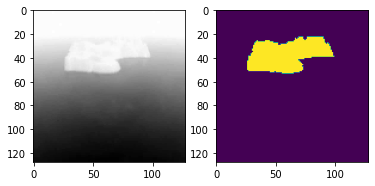

In [55]:
# Ok time to check we did a correct job on previous cells:
# select a batch and an frame index to change the image/seg couple
batch = 0
idx = 15

# grab corresponding images
# 0 and 1 indexes corresponds to X and Y respectively
img = np.squeeze(train_gen[batch][0][idx] * 255).astype(np.int)
seg = np.squeeze(train_gen[batch][1][idx] * 255).astype(np.int)

# and the show the images with matplotlib
fig, axes = plt.subplots(1,2)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(seg)
plt.show()

Ok At this point, we made the hardest part, now we need to define a Segmentation Model


Luckily, Keras already did it for us, so here we go for a copy/pasta safari: 
https://keras.io/examples/vision/oxford_pets_image_segmentation/

With some minus adaptations, it can fit our task pretty well

Here is an example of a Unet architecture from wikipedia (different in/output shape)


<img src="https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png"/>

## Building the Model

In [56]:
# this line will clean the model out from memory so we dont reuse the previous ones we tested before...
keras.backend.clear_session()

# here we define the model's input shape from previously defined img_dims
inputs = keras.layers.Input(shape=img_dims)
### [First half of the network: downsampling inputs] ###

# Entry block
x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128]:
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

### [Second half of the network: upsampling inputs] ###

for filters in [128, 64, 32]:
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.UpSampling2D(2)(x)

    # Project residual
    residual = keras.layers.UpSampling2D(2)(previous_block_activation)
    residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy") # Here I changed the loss to binary 
# let's print the model's summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [57]:
# And let the magic happens ! (feel free to try different epoch's number)
history = model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=1)

1600/1600 [==============================] - 1361s 850ms/step - loss: 0.0251 - val_loss: 0.0374


## Visualize Predictions

OK ! Nice, now we can check if our model performs as desired !

C:\Users\Rock_\AppData\Local\Temp/ipykernel_3872/3655903108.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Rock_\AppData\Local\Temp/ipykernel_3872/3655903108.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 3)


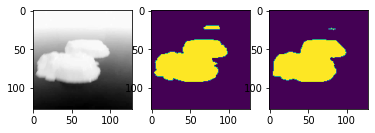

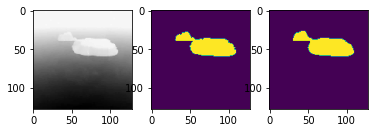

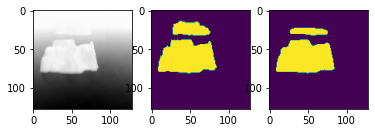

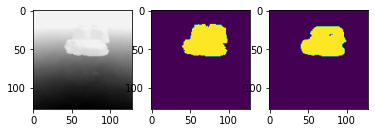

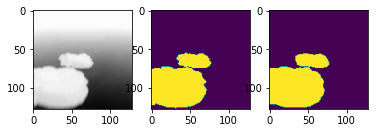

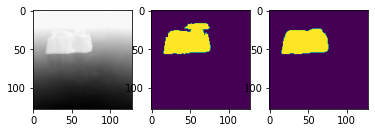

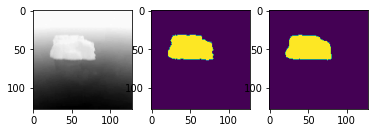

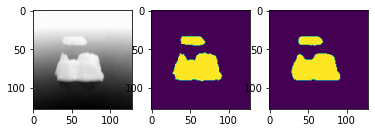

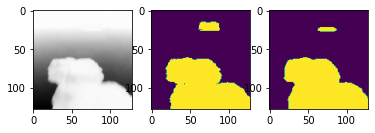

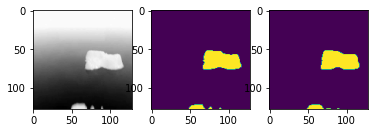

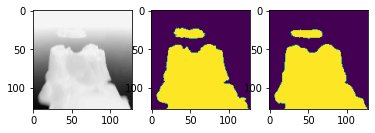

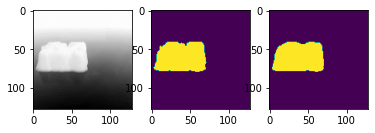

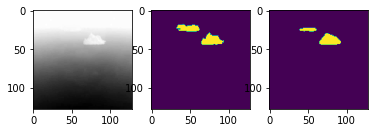

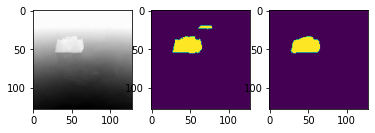

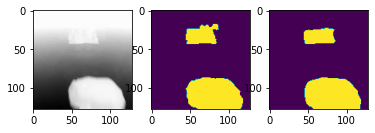

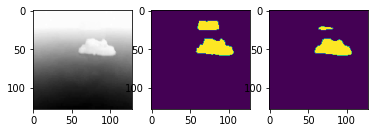

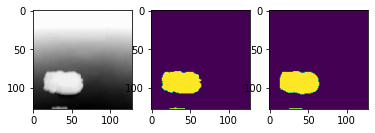

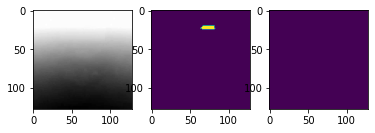

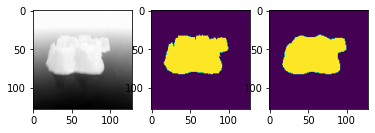

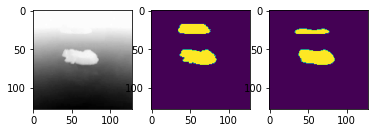

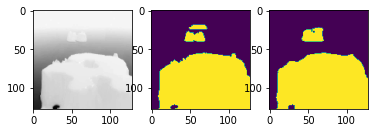

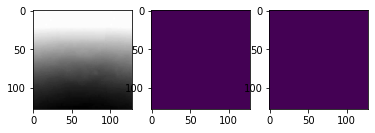

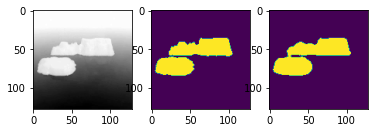

In [59]:
# So for every batch until N
N = 1 # we just check one batch here
for batch in range(N):
    # for every image/segmentation pair in batch
    for img, seg in zip(val_gen[batch][0], val_gen[batch][1]):
        
        # we predict the model's segmenation on this image ("un normalized" so [0, 255] values)
        pred = model.predict(np.expand_dims(img, axis=0)) * 255
        
        # threshold it so we only have 0 - 255 values in our mask
        _, pred_img = cv2.threshold(np.squeeze(pred), 128, 255, cv2.THRESH_BINARY)
        # then convert the numpy array to a PIL Image
        pred_img = Image.fromarray(pred_img.astype(np.uint8))
        
        # and finaly show the image, the real segmentation and the model's estimation !
        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(np.squeeze(img), cmap='gray')
        axes[1].imshow(np.squeeze(seg))
        axes[2].imshow(pred_img)
        fig.show()

# It Works !!

### What to do next ?

Well, whereas the model works, it certainely won't fit the submission's machine specs to predict all the test images in less than 10 minutes... (honestly I did not try, maybe it will...)

Now you have to tune the model (along with the data generator) so it can predict faster, while keeping the accuracy high...